In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
from implementations import *
from crossvalidation import *
from proj1_helpers import *
from preprocessing import *
from CV_modularised import *
from plots import *

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
DATA_TEST_PATH = 'data/test.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
features_name = np.genfromtxt('data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [4]:
tX_test.shape

(11365, 30)

# Data exploration

In [5]:
print("Our training features array tX is of shape:",tX.shape)
print("Our training response array y is of shape:",len(y))
print("Our training index array ids is of shape:",len(ids))
print("Our training features' names aray features_name is of shape:",len(features_name), ' \n')
print("Printing the first rows of tX:", tX[0:1,:], '\n')
print("Printing the binary values that can take y:", np.unique(y),'\n')
print("Printing the features' names:", features_name)

Our training features array tX is of shape: (5000, 30)
Our training response array y is of shape: 5000
Our training index array ids is of shape: 5000
Our training features' names aray features_name is of shape: 30  

Printing the first rows of tX: [[ 1.38470e+02  5.16550e+01  9.78270e+01  2.79800e+01  9.10000e-01
   1.24711e+02  2.66600e+00  3.06400e+00  4.19280e+01  1.97760e+02
   1.58200e+00  1.39600e+00  2.00000e-01  3.26380e+01  1.01700e+00
   3.81000e-01  5.16260e+01  2.27300e+00 -2.41400e+00  1.68240e+01
  -2.77000e-01  2.58733e+02  2.00000e+00  6.74350e+01  2.15000e+00
   4.44000e-01  4.60620e+01  1.24000e+00 -2.47500e+00  1.13497e+02]] 

Printing the binary values that can take y: [-1.  1.] 

Printing the features' names: ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' '

In [6]:
print("The number of Higgs signal particules is", len(y[y==1]), '-',round(len(y[y==1])*100/len(y),0),'%')
print("The number of background particules is", len(y[y==-1]), '-',round(len(y[y==-1])*100/len(y),0),'%')

The number of Higgs signal particules is 1643 - 33.0 %
The number of background particules is 3357 - 67.0 %


#### Boxplot analysis

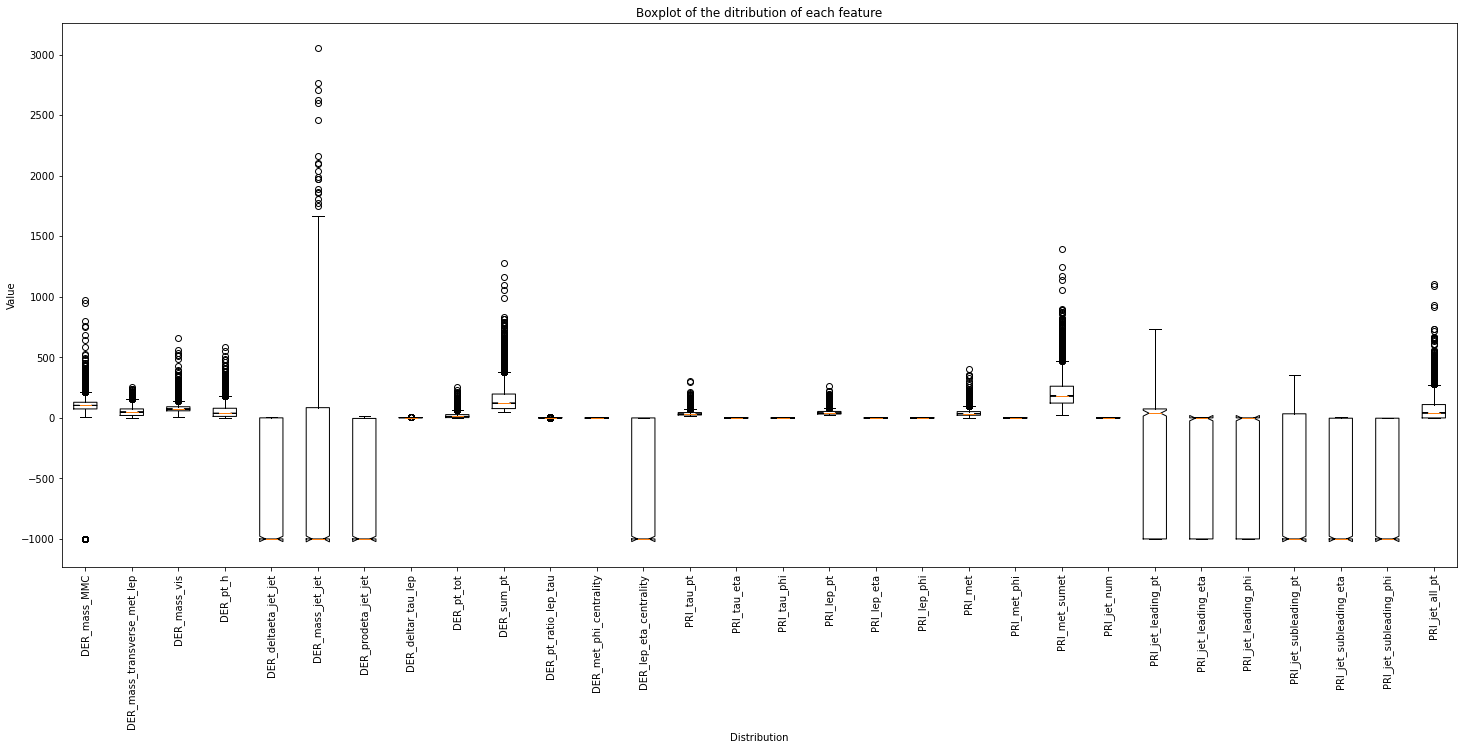

In [7]:
figure = plt.figure(figsize=(25,10))
plt.boxplot(tX, notch=True, labels = features_name, manage_ticks=True)
plt.xticks(rotation=90)
plt.xlabel('Distribution')
plt.ylabel('Value')
plt.title('Boxplot of the ditribution of each feature')
plt.show()

It is clear that some of features contain outliers, hence we will need to remove them in the processing part. 

#### Features classes

As we know there are only one feature that is an integer and categorical, we can take advantage of it to classify our features.

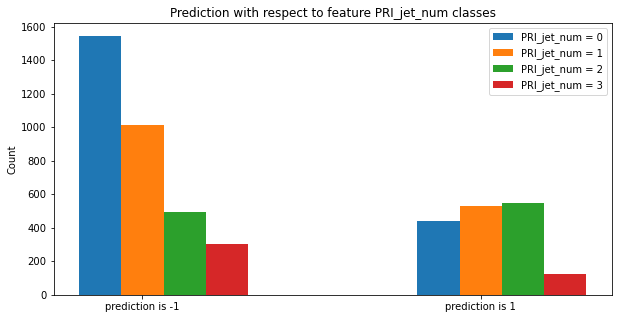

In [8]:
fig = plt.figure(figsize=(10,5))
feature_classes = {
    0: tX[:,22] == 0,
    1: tX[:,22] == 1,
    2: tX[:,22] == 2,
    3: tX[:,22] == 3,
}

labels = ['PRI_jet_num = 0', 'PRI_jet_num = 1', 'PRI_jet_num = 2', 'PRI_jet_num = 3']
w = 0.25

for i in range(len(feature_classes)):
    y_class = y[feature_classes[i]]
    plt.bar(i*w+np.array([-1,1]),[len(y_class[y_class==-1]),len(y_class[y_class==1])], width=w)

plt.xticks(np.array([-1,1]) + w, labels = ('prediction is -1', 'prediction is 1') )
plt.ylabel('Count')
plt.title('Prediction with respect to feature PRI_jet_num classes')
plt.legend(labels)
plt.show()

It seems that class 0 features have a prevalence on the background particule prediction, and the classes 0,1,2 have an impact on the signal particule prediction.

#### Features' distributions analysis

Let's analyse the distribution of each feature with respect to the label. These distributions will help us deduce which features are more important for classification and which are less important.

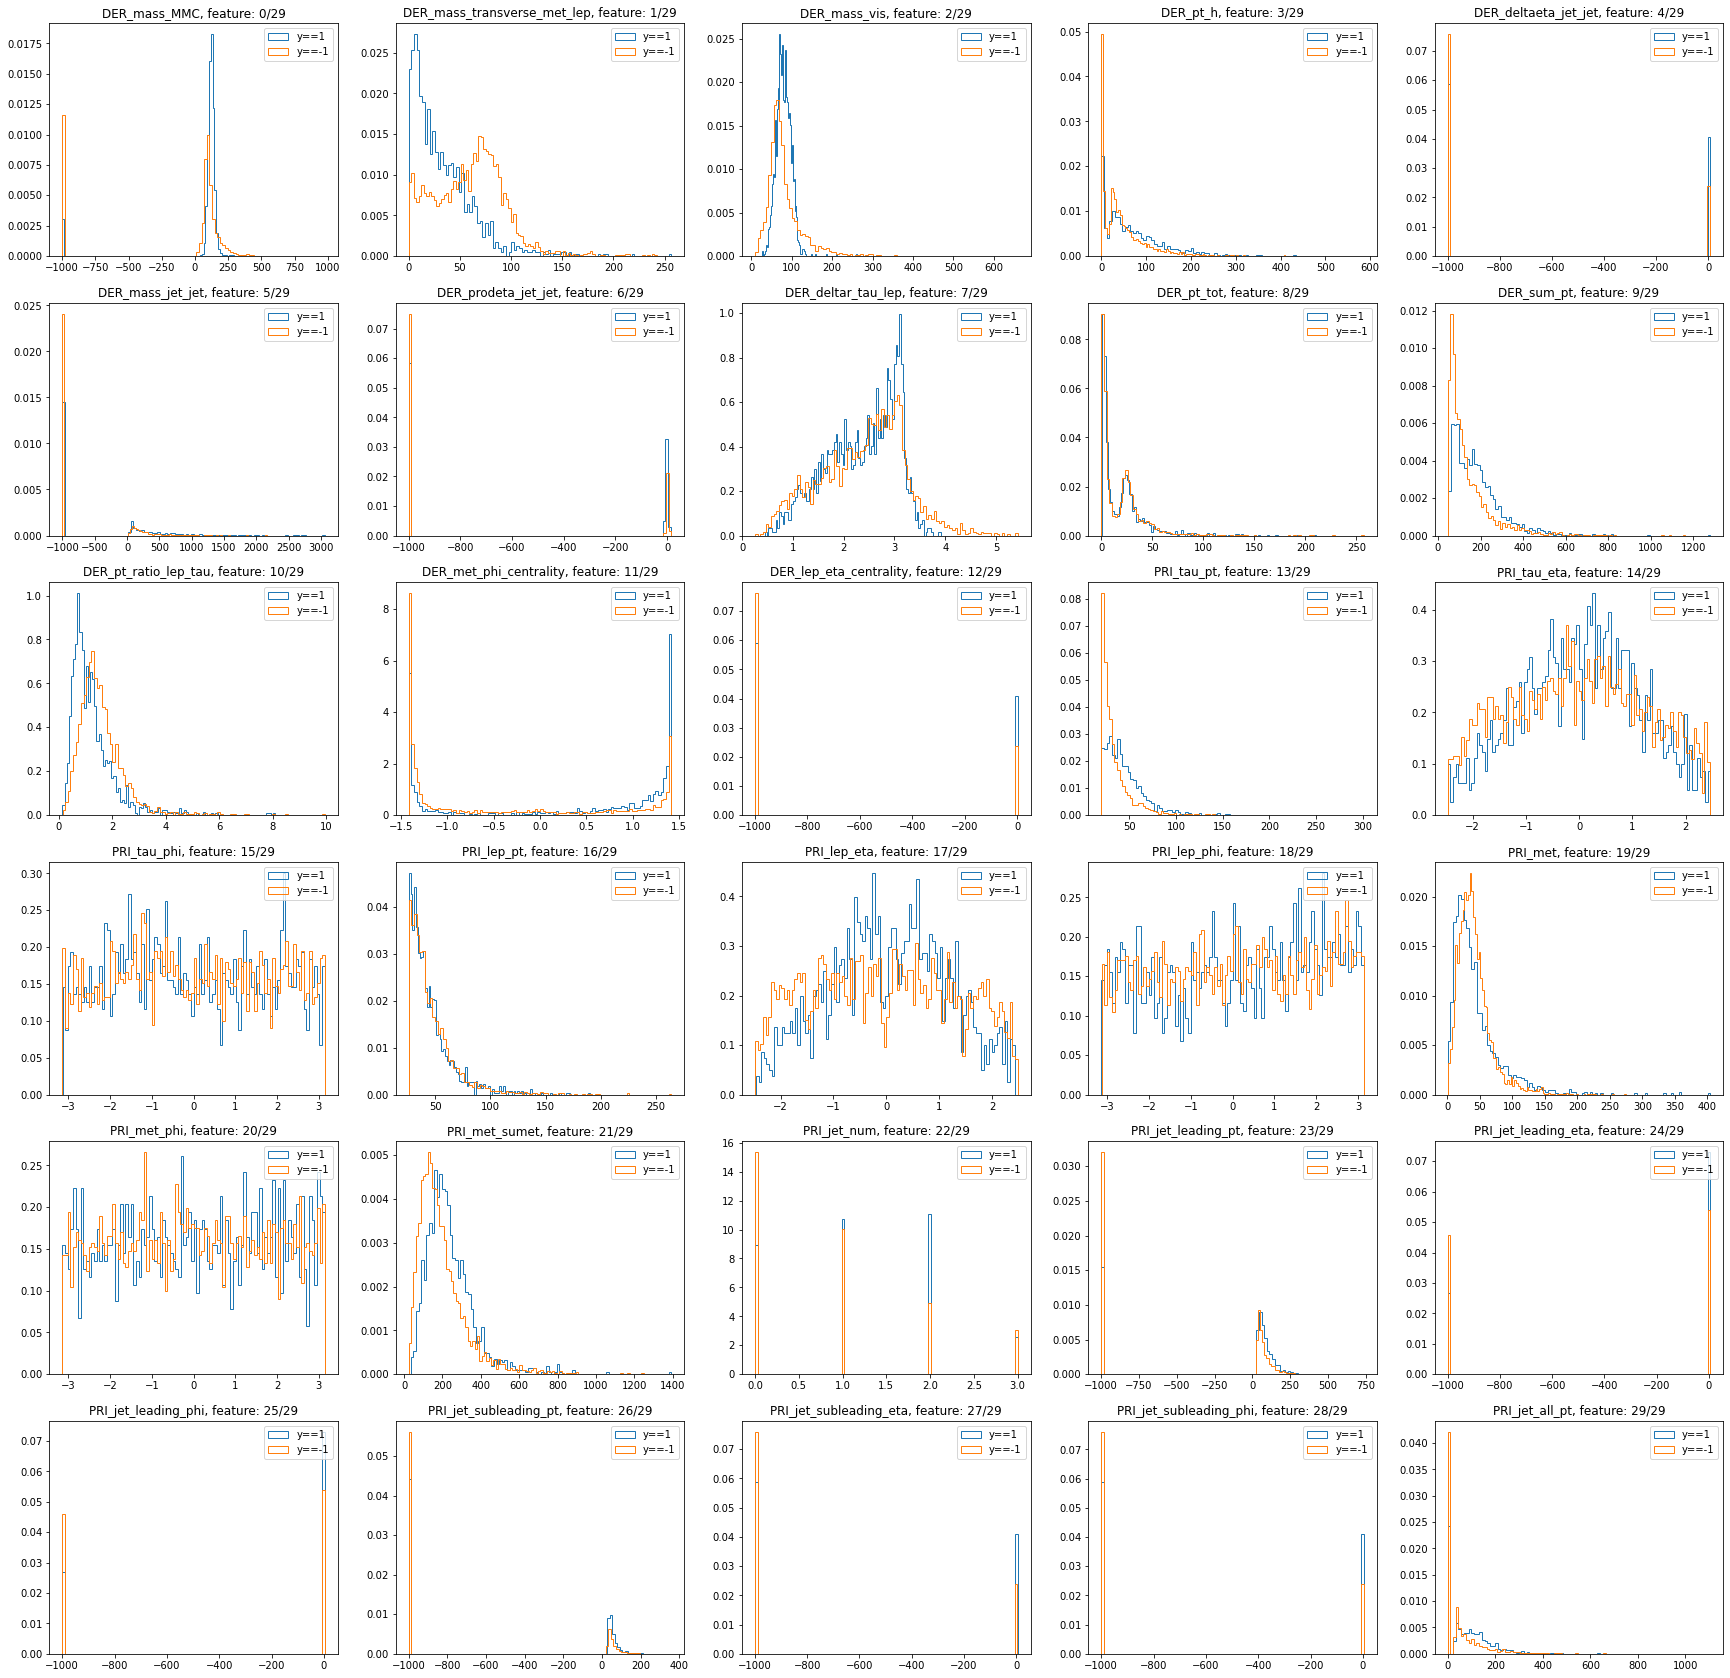

In [9]:
fig = plt.figure(figsize=(30,30))

for i in range(tX.shape[1]):
    ax = plt.subplot(6, 5, i+1)
    ax.hist(tX[[y==1][0], i], bins=100, histtype='step', label="y==1", density=True)
    ax.hist(tX[[y==-1][0], i], bins=100, histtype='step', label="y==-1", density=True)
    plt.legend()
    plt.title("{name}, feature: {id}/{tot}".format(name=features_name[i],id=i,tot=len(features_name)-1), fontsize=12)

plt.show()

## Feature processing

In [10]:
# delete outliers :
print('Outliers process :')
print('On training set :')
tX_, y_ = outliers(tX, y)
print('On test set :')
tX_test_, y_test_ = outliers(tX_test, y_test)
print(' ')

# we can deal with the missing values (see preprocessing file to see what the function does)
# warning : it is important that no features were removed before this point !
# (else the feature 'PRI_jet_num' would not be at the same position)
print('Missing values process :')
# tX_, tX_test_ = missing_values(tX_, tX_test_)
print(' ')

# remove useless features
print('Useless features process :')
tX_, tX_test_= remove_useless_features(tX_, tX_test_)
print(' ')

# standardize :
tX_, mean, std = standardize(tX_)
tX_test_, mean_, std_ = standardize(tX_test_, mean, std)

# first, we add a column of 1 to our X matrices :
tX_ = offset(tX_)
tX_test_ = offset(tX_test_)

print('Shape of the preprocessed training set : ', tX_.shape)
print(' ')
print('Head of the preprocessed training set')
print(tX_[:5,])

# feature engineering
#...

Outliers process :
On training set :
With outliers :  (5000, 30)
Without outliers :  (3245, 30)
On test set :
With outliers :  (11365, 30)
Without outliers :  (7471, 30)
 
Missing values process :
 
Useless features process :
4  useless features have been removed
0  features with a standard deviation equal to 0 have been removed
 
Shape of the preprocessed training set :  (3245, 27)
 
Head of the preprocessed training set
[[ 1.          0.92738242  0.38368138  1.09060445 -0.4330477   1.69921591
   1.31371988  1.71115875  0.87749928  1.75773664  1.0605089   0.40174588
   1.21292505  1.7023129  -0.16378334  0.8570755   1.8193426  -0.81088709
   0.92545961  1.22854193  0.82153935  0.82249844  0.81900732  1.70115375
   1.70575904  1.69752464  1.03121397]
 [ 1.         -0.58856316 -0.47643224 -0.45335994  0.31423413 -0.58719468
  -0.56606302 -0.58719019 -0.07762396  0.31600902  0.1404134   1.90393703
   1.22043345 -0.58719582 -1.01588693  1.34362327  1.50036137 -0.73120358
   0.43601838  0.

## Applying methods

In [11]:
seed = np.random.seed(10)

### Method 1 : least_squares_GD

#### "Parameters pre-tunage"

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:14: RuntimeWarning: overflow encountered in square
  mse = 1/2*np.mean(e**2)
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:118: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad


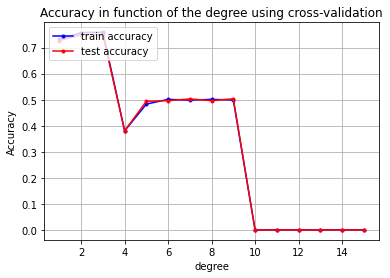

Accuracies for different degree :
[0.7271886559802713, 0.75, 0.748766954377312, 0.3803945745992602, 0.4938347718865598, 0.4963008631319359, 0.5027743526510481, 0.4963008631319359, 0.5033908754623921, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


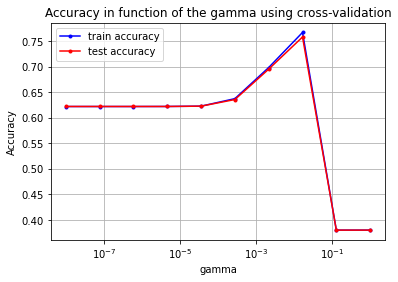

Accuracies for different gamma :
[0.6220715166461159, 0.6220715166461159, 0.6220715166461159, 0.6220715166461159, 0.6226880394574599, 0.6356350184956843, 0.6951294697903823, 0.7580147965474723, 0.38008631319358815, 0.38008631319358815]


In [12]:
#Fixed parameters :
k_fold=4
max_iters = 50

#Parameters to tune :
degrees = 1+np.arange(15)
gamma=0.01

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares_GD, seed=seed, params=degrees, gamma=gamma, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas=np.logspace(-8, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, least_squares_GD, seed=seed, params=gammas, degree=degree, max_iters=max_iters, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [99]:
degrees = [1, 2, 3, 4]
gammas = np.linspace(0.001, 0.003, 5)

#### Parameters tunage

In [100]:
# cross validation
deg_ls_gd, gamma_ls_gd, acc_te_ls_gd, acc_tr_ls_gd = tune_best_deg_gam(y_, tX_, k_fold, least_squares_GD, degrees=degrees, gammas=gammas, seed=seed, max_iters=max_iters)
print('The degree obtaining the maximum test accuracy is : ', deg_ls_gd)
print(' ')
print('Combined with a best learning rate gamma : ', gamma_ls_gd)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls_gd)
print(' ')
print('While the train accuracy is : ', acc_tr_ls_gd)

The degree obtaining the maximum test accuracy is :  3
 
Combined with a best learning rate gamma :  0.001
 
And the associated maximum test accuracy is :  0.715782983970407
 
While the train accuracy is :  0.7216399506781751


### Method 2 : least_squares_SGD

#### "Parameters pre-tunage"

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:14: RuntimeWarning: overflow encountered in square
  mse = 1/2*np.mean(e**2)
C:\Users\theau\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:171: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad


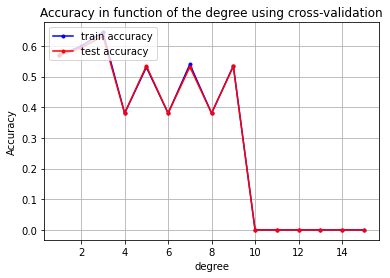

Accuracies for different degree :
[0.5696670776818742, 0.593094944512947, 0.6316276202219482, 0.3803945745992601, 0.5348335388409371, 0.3803945745992601, 0.5314426633785451, 0.3803945745992601, 0.532983970406905, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


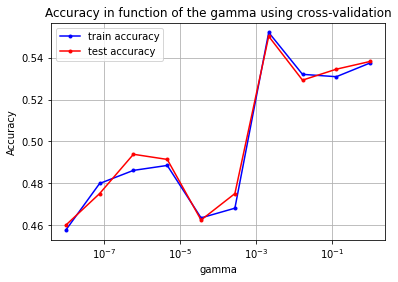

Accuracies for different gamma :
[0.4599260172626387, 0.47503082614056724, 0.49383477188655983, 0.4913686806411837, 0.4623921085080148, 0.4750308261405672, 0.5502466091245375, 0.5292848335388409, 0.5345252774352651, 0.5382244143033292]


In [101]:
#Fixed parameters :
k_fold=4
max_iters = 50
batch_size = int(np.floor(tX_.shape[0]*0.1))

#Parameters to tune :
degrees = 1+np.arange(15)
gamma=0.01

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares_SGD, seed=seed, params=degrees, gamma=gamma, batch_size=batch_size, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas=np.logspace(-8, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, least_squares_SGD, seed=seed, params=gammas, degree=degree, max_iters=max_iters, batch_size=batch_size, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [106]:
degrees = [1, 2, 3, 4]
gammas = np.linspace(0.001, 0.005, 5)

#### Parameters tunage

In [107]:
# cross validation
deg_ls_sgd, gamma_ls_sgd, acc_te_ls_sgd, acc_tr_ls_sgd = tune_best_deg_gam(y_, tX_, k_fold, least_squares_SGD, degrees=degrees, gammas=gammas, seed=seed, batch_size=batch_size, max_iters=max_iters)
print('The degree obtaining the maximum test accuracy is : ', deg_ls_sgd)
print(' ')
print('Combined with a best learning rate gamma : ', gamma_ls_sgd)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls_sgd)
print(' ')
print('While the train accuracy is : ', acc_tr_ls_sgd)

The degree obtaining the maximum test accuracy is :  1
 
Combined with a best learning rate gamma :  0.002
 
And the associated maximum test accuracy is :  0.5496300863131935
 
While the train accuracy is :  0.5462392108508015


### Method 3 : least_squares

#### Parameters tunage

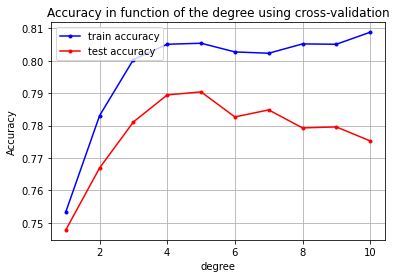

The degree obtaining the maximum test accuracy is :  4
 
And the associated maximum test accuracy is :  0.7857583230579531
 
While the train accuracy is :  0.8054870530209618


In [109]:
# parameters
degrees = 1+ np.arange(10)
k_fold = 4

#Plot
best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, least_squares, seed=seed, params=degrees, name='degree')
CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

# cross validation

deg_ls, acc_te_ls, acc_tr_ls = tune_best_deg(y_, tX_, k_fold, least_squares, degrees=degrees, seed=seed)
print('The degree obtaining the maximum test accuracy is : ', deg_ls)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_ls)
print(' ')
print('While the train accuracy is : ', acc_tr_ls)

### Method 4 : ridge_regression

#### "Parameters pre-tunage"

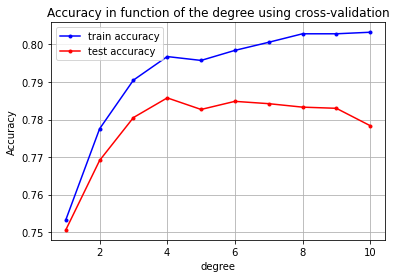

Accuracies for different degree :
[0.7506165228113441, 0.7691122071516646, 0.7805178791615289, 0.7857583230579531, 0.782675709001233, 0.7848335388409371, 0.7842170160295932, 0.783292231812577, 0.782983970406905, 0.7783600493218249]


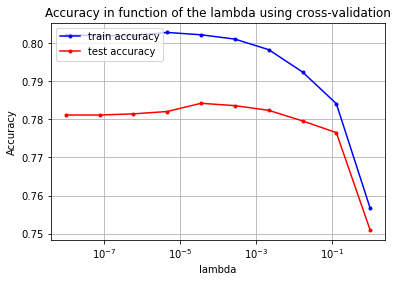

Accuracies for different lambda :
[0.4599260172626387, 0.47503082614056724, 0.49383477188655983, 0.4913686806411837, 0.4623921085080148, 0.4750308261405672, 0.5502466091245375, 0.5292848335388409, 0.5345252774352651, 0.5382244143033292]


In [117]:
# parameters
k_fold = 4

#Parameters to tune :
degrees = 1+ np.arange(10)
lambda_ = 1e-03 

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, ridge_regression, seed=seed, params=degrees, lambda_=lambda_, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
lambdas = np.logspace(-8, 0, 10)

best_lam, acc_te_lam, acc_tr_lam = tune_best_one(y_, tX_, k_fold, ridge_regression, seed=seed, params=lambdas, degree=degree, name='lambda')

CV_param_plot(lambdas, acc_tr_lam, acc_te_lam, name_param="lambda")

print("Accuracies for different lambda :")
print(acc_te_lam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [118]:
degrees = [3, 4, 5]
lambdas = np.logspace(-5, -3, 5)

#### Parameters tunage

In [119]:
# cross validation
deg_rr, lambda_rr, acc_te_rr, acc_tr_rr = tune_best_deg_lam(y_, tX_, k_fold, ridge_regression, degrees=degrees, lambdas=lambdas, seed=seed)

print('The degree obtaining the maximum test accuracy is : ', deg_rr)
print(' ')
print('With a lambda equal to : ', lambda_rr)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_rr)
print(' ')
print('While the train error is : ', acc_tr_rr)

The degree obtaining the maximum test accuracy is :  4
 
With a lambda equal to :  0.0001
 
And the associated maximum test accuracy is :  0.780209617755857
 
While the train error is :  0.7982942868886149


### Method 5 : logistic_regression

#### "Parameters pre-tunage"

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:255: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold) :


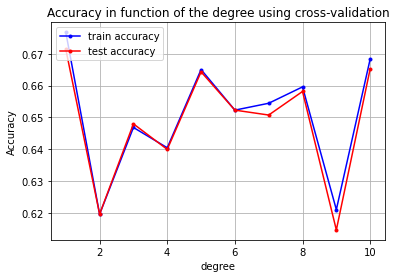

Accuracies for different degree :
[0.6713933415536375, 0.6196054254007398, 0.6479654747225647, 0.6399506781750925, 0.6643033292231812, 0.6522811344019729, 0.6507398273736128, 0.6581381011097411, 0.6146732429099877, 0.6652281134401973]


C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:255: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold) :


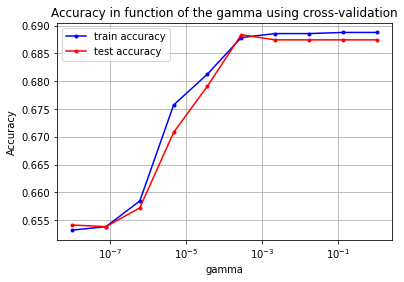

Accuracies for different gamma :
[0.6541307028360048, 0.6538224414303329, 0.657213316892725, 0.6707768187422934, 0.6790998766954378, 0.688347718865598, 0.6874229346485821, 0.6874229346485821, 0.6874229346485821, 0.6874229346485821]


In [125]:
# parameters
k_fold = 4
max_iters = 50

#Parameters to tune :
degrees = 1+ np.arange(10)
gamma = 1e-05

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, logistic_regression, seed=seed, params=degrees, gamma=gamma, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree = best_degree
gammas = np.logspace(-8, 0, 10)

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, logistic_regression, seed=seed, params=gammas, degree=degree, max_iters=max_iters, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [129]:
degrees = [1, 2, 3]
gammas = np.logspace(-4, -3, 5)

#### Parameters tunage

In [130]:
# cross validation
deg_lr, gam_lr, acc_te_lr, acc_tr_lr = tune_best_deg_gam(y_, tX_, k_fold, logistic_regression, degrees=degrees, gammas=gammas, max_iters=max_iters, log=True, seed=seed)

print('The degree obtaining the maximum test accuracy is : ', deg_lr)
print(' ')
print('With a learning rate equal to : ', gam_lr)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_lr)
print(' ')
print('While the train accuracy is : ', acc_tr_lr)

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:255: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold) :


The degree obtaining the maximum test accuracy is :  1
 
With a learning rate equal to :  0.0001
 
And the associated maximum test accuracy is :  0.6818742293464858
 
While the train accuracy is :  0.6867036580353473


### Method 6 : reg_logistic_regression

#### "Parameters pre-tunage"

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:300: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold):
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))


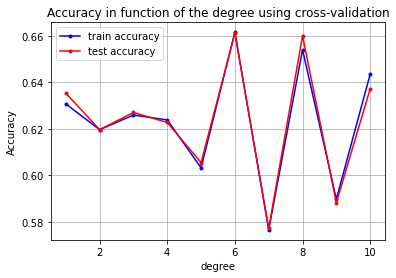

Accuracies for different degree :
[0.6353267570900123, 0.6196054254007398, 0.6270036991368682, 0.6226880394574599, 0.6054254007398273, 0.6612207151664611, 0.5770653514180024, 0.6599876695437732, 0.5881627620221949, 0.6371763255240444]


C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:300: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold):


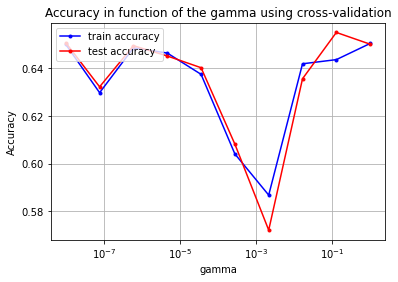

Accuracies for different gamma :
[0.6507398273736129, 0.6322441430332922, 0.6495067817509248, 0.6451911220715166, 0.6402589395807645, 0.6081997533908755, 0.5721331689272503, 0.6356350184956843, 0.655055487053021, 0.6501233045622689]


C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:300: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold):


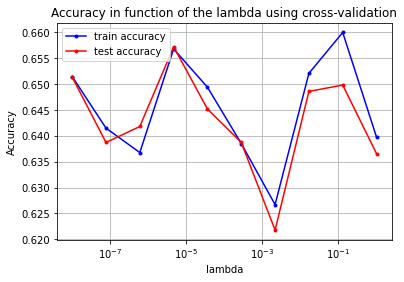

Accuracies for different lambda :
[0.6513563501849569, 0.6387176325524044, 0.6418002466091245, 0.6572133168927251, 0.6451911220715166, 0.6387176325524044, 0.6217632552404438, 0.6485819975339088, 0.6498150431565968, 0.6365598027127004]


In [133]:
# parameters
k_fold = 4
max_iters=50


#Parameters to tune :
degrees=1+ np.arange(10)
gamma=0.0001
lambda_=1e-5

best_degree, acc_te_deg, acc_tr_deg = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=degrees, gamma=gamma, lambda_=lambda_, max_iters=max_iters, name='degree')

CV_param_plot(degrees, acc_tr_deg, acc_te_deg, name_param="degree")

print("Accuracies for different degree :")
print(acc_te_deg)

#Parameters to tune :
degree=best_degree
gammas=np.logspace(-8, 0, 10)
lambda_=1e-5

best_gam, acc_te_gam, acc_tr_gam = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=gammas, degree=degree, lambda_=lambda_, max_iters=max_iters, name='gamma')

CV_param_plot(gammas, acc_tr_gam, acc_te_gam, name_param="gamma")

print("Accuracies for different gamma :")
print(acc_te_gam)

#Parameters to tune :
degree=best_degree
gamma=best_gam
lambdas=np.logspace(-8, 0, 10)

best_lam, acc_te_lam, acc_tr_lam = tune_best_one(y_, tX_, k_fold, reg_logistic_regression, seed=seed, params=lambdas, degree=degree, gamma=gamma, max_iters=max_iters, name='lambda')

CV_param_plot(lambdas, acc_tr_lam, acc_te_lam, name_param="lambda")

print("Accuracies for different lambda :")
print(acc_te_lam)

Using this "pre-tunage", we can apply tune simultanesouly degree and gamma on a smaller grid search (to avoid very long computation).

In [135]:
degrees=[1, 2, 3]
gammas=np.logspace(-2, 0, 3)
lambdas=np.logspace(-5, -4, 5)

#### Parameters tunage

In [136]:
# cross validation
deg_lr_reg, gam_lr_reg, lambda_lr_reg, acc_te_lr_reg, acc_tr_lr_reg = tune_best_deg_lam_gam(y_, tX_, k_fold, reg_logistic_regression, degrees=degrees,
                                                                 lambdas=lambdas, gammas=gammas, log=True, seed=seed) 

print('The degree obtaining the maximum test accuracy is : ', deg_lr_reg)
print(' ')
print('With a gamma equal to : ', gam_lr_reg)
print(' ')
print('and a lambda equal to : ', lambda_lr_reg)
print(' ')
print('And the associated maximum test accuracy is : ', acc_te_lr_reg)
print(' ')
print('While the train accuracy is : ', acc_tr_lr_reg)

C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:52: RuntimeWarning: overflow encountered in exp
  return 1/ (1 + np.exp(-t))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:34: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1+np.exp(tx@w))-y*(tx@w))
C:\Users\theau\OneDrive\Documents\Théau EPFL\9.MA1\Machine learning\ML_project1\ml-project-1-thevipers\implementations.py:300: RuntimeWarning: invalid value encountered in double_scalars
  if (len(losses) > 1) and (np.abs(losses[-1] - losses[-2]) < threshold):


The degree obtaining the maximum test accuracy is :  1
 
With a gamma equal to :  0.1
 
and a lambda equal to :  1e-05
 
And the associated maximum test accuracy is :  0.6812577065351417
 
While the train accuracy is :  0.6812577065351418


## Compare methods

## Generate predictions and save ouput in csv format for submission:

In [11]:
OUTPUT_PATH = 'data/first_submission.csv' # TODO: fill in desired name of output file for submission

In [12]:
tX

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [13]:
tX_deg4 = build_poly(tX, 4)
tX_test_deg4 = build_poly(tX_test,4)

In [14]:
w, _ = least_squares(y, tX_deg4)

In [15]:
w.shape

(121,)

In [16]:
tX_test.shape

(568238, 30)

In [17]:
y_pred = predict_labels(w, tX_test_deg4)

In [18]:
y_pred

array([-1., -1., -1., ..., -1., -1., -1.])

In [19]:
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)